In [32]:
import copy
import time
import numpy as np
import pandas as pd
from control.matlab import *
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [33]:
# Fix all random sources to make script fully reproducible
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [34]:
import pickle as pkl

with open('../../data/control/test_set_simple_example_1_20%_perturbation.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

In [35]:
from VRFT_ry import VRFT_ry

ts = 1e-2; fs = 1/ts
s = tf('s')
z = tf([1, 0], [1], dt=ts)

# VRFT
s = tf('s')
tau = .5 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')
# M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
W = 1/(1 + (10*tau/(2*np.pi))*s)
W = c2d(W, ts, 'matched')

L = M# minreal( minreal((1 - M)*M)*minreal(W*U**-1) )

B=[tf([1],[1],ts),
   tf(ts*np.array([1, 1]),2*np.array([1, -1]),ts),
   tf(np.array([2, -2]),ts*np.array([3, -1]),ts)]

# Specifics for OL experiment
T = 20
t = np.arange(0, T, ts)

# Specifics for CL experiment
T_CL = 20
t_CL = np.arange(0, T_CL, ts)
r = np.zeros(t_CL.shape)
r[t_CL < 10] = 10
r[(t_CL >= 2.5) & (t_CL < 5)] = -10
r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
r[(t_CL >= 7.5) & (t_CL < 10)] = 5
r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20
y_d = lsim(M, r, t_CL, return_x=False)[0]

# To store results
U = np.zeros((len(data_test), len(t)))
Y = np.zeros((len(data_test), len(t)))
E = np.zeros((len(data_test), len(t)))
Y_CL = np.zeros((len(data_test), len(t)))

for i, data in enumerate(data_test):
    
    num = [data['num_1']]
    den = [data['den_1'], data['den_2'], data['den_3']]

    G_continuous = tf(num,den)
    G = c2d(G_continuous, ts, 'matched')
    
    U[i,:] = np.random.normal(0, 1000, t.shape)
    Y[i,:] = lsim(G, U[i,:], t)[0] + np.random.normal(0, 2, t.shape)
    
    theta, C, E[i,:] = VRFT_ry(U[i,:], Y[i,:], M, B, return_error=True)
    
    F = C*G/(1 + C*G)
    
    Y_CL[i,:] = lsim(F, r, t_CL, return_x=False)[0] + np.random.uniform(0, 2, t_CL.shape)

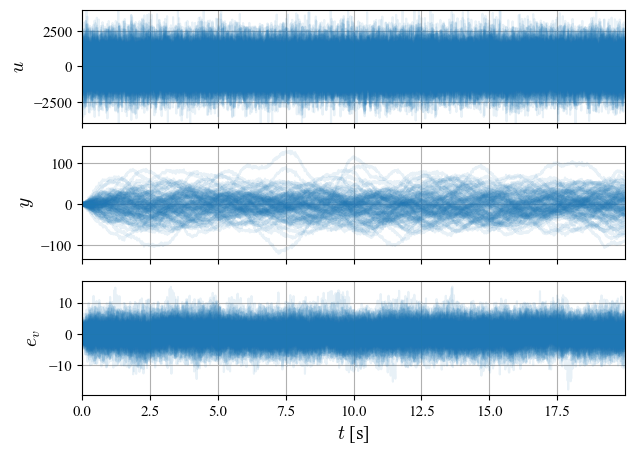

In [36]:
fig = plt.figure(figsize=(7, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t, U.T, label="$u$", c='tab:blue', alpha=0.1)
# plt.legend()
# plt.xlim([0, 0.43])
plt.ylim([-4000, 4000])
plt.ylabel("$u$")
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t, Y.T, label="$y$", c='tab:blue', alpha=0.1)
plt.tick_params('x', labelbottom=False)
# plt.xlabel("$t$ [s]")
plt.ylabel("$y$")

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t, E.T, label="$e_v$", c='tab:blue', alpha=0.1)
plt.xlabel("$t$ [s]")
plt.ylabel("$e_v$")
# plt.legend()
plt.show()

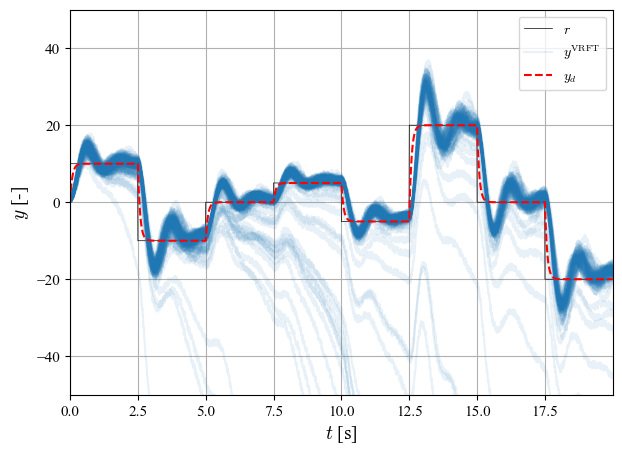

In [37]:
fig = plt.figure(figsize=(7, 5))
plt.plot(t_CL, r, color='k', linewidth=0.5, label='$r$')
plt.plot(t_CL, Y_CL[0,:], label=r'$y^{\mathrm{VRFT}}$', color='tab:blue', alpha=.1)
plt.plot(t_CL, Y_CL.T, label=None, color='tab:blue', alpha=.1)
plt.plot(t_CL, y_d, color='r', linestyle='--', label='$y_d$')
plt.xlabel("$t$ [s]")
plt.ylabel("$y$ [-]")
plt.ylim([-50, 50])
plt.legend()
plt.margins(x=0)
plt.show()